In [1]:
import asyncio
import nest_asyncio
import motor.motor_asyncio
from datetime import date, datetime, timedelta
from collections import defaultdict
import pprint
import sys
import pandas as pd
import numpy as np
import ta
import os
import matplotlib.pyplot as plt
import talib
import pyfolio as pf

from ipywidgets import IntProgress
from IPython.display import display

import backtrader as bt
import backtrader.feeds as btfeeds

nest_asyncio.apply()
%matplotlib inline

sys.path.insert(0, os.path.abspath('../'))
import abupy
from abupy.UtilBu.ABuDateUtil import str_to_datetime

C:\Users\sean.chen\AppData\Local\Continuum\anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +
C:\Users\sean.chen\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
NumExpr defaulting to 8 threads.


In [2]:
client = motor.motor_asyncio.AsyncIOMotorClient('mongodb://localhost:27017')
db = client['symbol-db']
loop = asyncio.get_event_loop()

In [3]:
async def do_find_symbol_correlation(symbol, S_endDate, S_startDate):
    pipeline = [
        {"$match":{ "$expr": {"$and": [
            { "$lte" : ["$date", S_endDate ]},
            { "$gte" : ["$date", S_startDate ]},
            { "$eq" : ["$symbol", symbol]}
            ]}
        }},
        {"$project": {"_id": 0 } } # no _id to next pipeline
    ]
    collect = db['StockHisData'].aggregate(pipeline, allowDiskUse=True)
    results = []
    async for cursor in collect: # clean cursor ptr and store to list
        results.append(cursor)
    df = pd.DataFrame(results)
    try:
        df = df.set_index('date').dropna().sort_index()
        df = df.drop(columns=['symbol'])
    except Exception as e:
        pass
    return df

In [4]:
async def do_find_Institution_correlation(symbol, I_endDate, I_startDate):
    pipeline = [
        {"$match":{ "$expr": {"$and": [
            { "$lte" : ["$date", I_endDate ]},
            { "$gte" : ["$date", I_startDate ]},
            { "$eq" : ["$symbol", symbol]}
            ]}
        }},
        {"$project": {"_id": 0,
                "ForV": "$ForeignInvestor",
                "InvV": "$InvestmentTrust",
                "DelV": "$DealerSelf",
                "date": "$date"
        } } # no _id to next pipeline
    ]
    collect = db['StockInstitutionInvest'].aggregate(pipeline, allowDiskUse=True)
    results = []
    async for cursor in collect: # clean cursor ptr and store to list
        results.append(cursor)
    df = pd.DataFrame(results)
    try:
        df = df.set_index('date').dropna().sort_index()
    except Exception as e:
        pass
    return df

In [11]:
yy, mm, dd = date.today().isoformat().split("-")[0:3]
cdate = "{0}-{1}-{2}".format(yy, mm, dd)
#cdate = '2020-05-04'
today = str_to_datetime(cdate)
S_endDate = today
S_startDate = S_endDate - timedelta(days=150)
I_endDate = today
I_startDate = I_endDate - timedelta(days=1)
symbol = '3008'

In [12]:
df3 = loop.run_until_complete(do_find_Institution_correlation(symbol, I_endDate, I_startDate))
df3

""


In [13]:
df1 = loop.run_until_complete(do_find_symbol_correlation(symbol, S_endDate, S_startDate))
df1['datetime'] = df1.index;
df1 = df1.rename(columns = {'O': 'open', 'H': 'high', 'L': 'low', 'C': 'close', 'V': 'volume'})
df3 = loop.run_until_complete(do_find_Institution_correlation(symbol, I_endDate, I_startDate))
df1 = pd.concat([df1, df3],  axis=1, join="outer")
df1.iloc[[0]]
#df1.iloc[[-1]] 

,open,high,low,close,volume,datetime
date,,,,,,
2021-01-22,2875.0,2965.0,2860.0,2940.0,1419144.0,2021-01-22


In [14]:
class PandasDataOptix(btfeeds.PandasData):

    # 三大法人
    lines = ('ForV', 'InvV', 'DelV',)
    params = (('ForV', -1),
              ('InvV', -1),
              ('DelV', -1))
    
    if False:
        # No longer needed with version 1.9.62.122
        datafields = btfeeds.PandasData.datafields+ (
            ['ForV', 'InvV', 'DelV'])

<IPython.core.display.Javascript object>


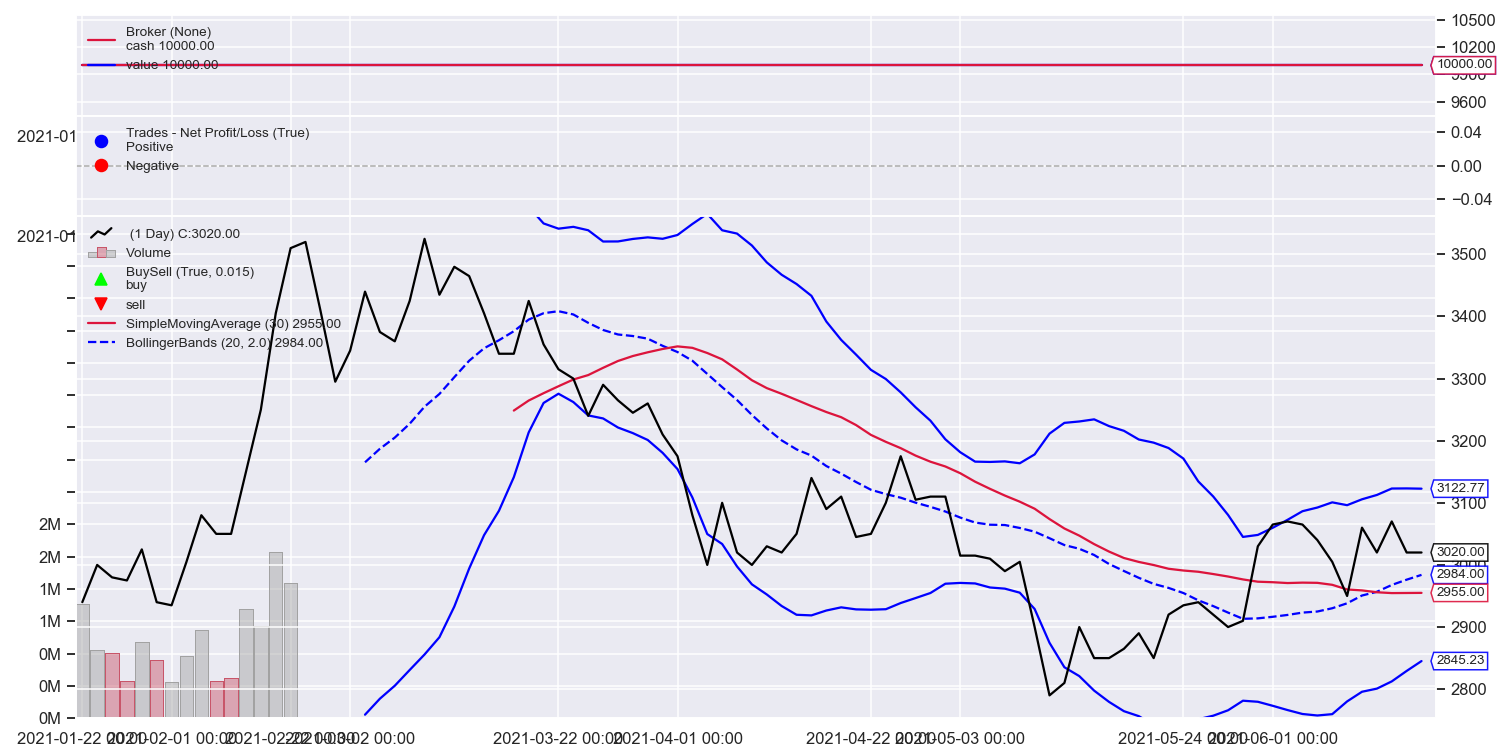

[[<Figure size 1008x504 with 4 Axes>]]

In [15]:
class Ind(bt.Strategy):

    params = (
        ('smaperiod', 15),
        ('exectype', 'Market'),
        ('valid', 4),
    )
        
    def __init__(self):
        self.sma = bt.indicators.SimpleMovingAverage(self.data)
        self.bband = bt.indicators.BollingerBands(self.data)
        self.dfx = pd.DataFrame()
       # Sentinel to None: new ordersa allowed
        self.order = None

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.data.datetime[0]
        if isinstance(dt, float):
            dt = bt.num2date(dt)
        print('%s, %s' % (dt.isoformat(), txt))        
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            self.log('ORDER ACCEPTED/SUBMITTED', dt=order.created.dt)
            self.order = order
            return

        if order.status in [order.Expired]:
            self.log('BUY EXPIRED')

        elif order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

        # Sentinel to None: new orders allowed
        self.order = None        
        
    def rolling_timewindow(self):
        if self.dfx.index.size == 50:
            self.dfx = self.dfx.iloc[1:]
            
        d = {
            'O': [self.data.open[0]],
            'H': [self.data.high[0]],
            'L': [self.data.low[0]],
            'C': [self.data.close[0]],
            'V': [self.data.volume[0]],
            'ForV': [self.data.ForV[0]],
            'InvV': [self.data.InvV[0]],
            'datetime': [self.data.datetime[0]] 
        }
        df = pd.DataFrame(data=d)
        df.index = df['datetime']
        self.dfx = self.dfx.append(df)
   
    def call_entry_condition(self):
        idx_last = np.where((self.dfx['L'] == self.dfx['L'].min()))[0][-1]
        cnds = [
            (((self.dfx.iloc[idx_last+1:]['L'] > self.dfx.iloc[idx_last]['L']).sum() == self.dfx.iloc[idx_last+1:].index.size) and (self.dfx.iloc[idx_last+1:].index.size < 4)),
            ((self.dfx.iloc[idx_last-4:idx_last]['V']).mean() *1.5 < self.dfx.iloc[idx_last]['V']),
            (((self.dfx.iloc[idx_last-4:]['ForV'] > 0) & (self.dfx.iloc[idx_last-4:]['InvV'] > 0)).sum() > 1),
            ((self.dfx.iloc[idx_last]['L'] * 1.05 < self.dfx.iloc[idx_last]['C']))
        ]
        if sum([cnd for cnd in cnds]) == len(cnds):
            return 1 
        return 0
    
    def call_leave_condition(self):
        if self.position:
            if self.position.price *0.9 >= self.data.low[0]:
                return 1
            if self.position.price *1.1 <= self.data.low[0]:
                return 1
            if self.selldate <= self.data.datetime.date(0):
                return 1
        return 0
    
    def next(self):
        self.rolling_timewindow()
        self.buysell  = 1 if self.call_entry_condition() else 0
        self.buysell = -1 if self.call_leave_condition() else self.buysell
        
        if self.order:
            # An order is pending ... nothing can be done
            return

        # Check if we are in the market
        if self.position:
            # In the maerket - check if it's the time to sell
            if self.buysell < 0:
                self.log('SELL CREATE, %.2f' % self.data.close[0])
                self.sell()

        elif self.buysell > 0:
            if self.p.valid:
                self.selldate = self.data.datetime.date(0) + \
                        timedelta(days=self.p.valid)
                
            # Not in the market and signal to buy
            if self.p.exectype == 'Market':
                self.buy(exectype=bt.Order.Market)  # default if not given
                self.log('BUY CREATE, exectype Market, price %.2f' %
                    self.data.close[0])

# 
data = PandasDataOptix(dataname=df1)

cerebro = bt.Cerebro()
cerebro.adddata(data)
cerebro.addstrategy(Ind)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio',  timeframe=bt.TimeFrame.Days)

results = cerebro.run()
strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
cerebro.plot()

In [16]:
start_date = df1.iloc[[1]].index.strftime("%Y-%m-%d")[0]

#print (positions)
#print (transactions)
#print (returns)

pf.create_full_tear_sheet(
        returns,
        positions=positions,
        transactions=transactions,
        #gross_lev=gross_lev,
        set_context=None,
        live_start_date=start_date)

IndexError: index -1 is out of bounds for axis 0 with size 0